In [247]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from matplotlib.colors import Normalize

In [248]:
# Load the datasets from CSV files
ratings = pd.read_csv('../data/ratings.csv')
movies = pd.read_csv('../data/movies.csv')

# Pivot the ratings DataFrame to create a matrix with userIds as rows, movieIds as columns, and ratings as values
data_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

# Add all the movieIds to the columns of the data_matrix
all_movie_ids = movies['movieId'].values
data_matrix = data_matrix.reindex(columns=all_movie_ids)

# Initialize dictionaries to map user IDs and movie IDs to their corresponding matrix indices
user_index_map = {}
movie_index_map = {}

movie_genres = {}

for row in movies.itertuples():
    index = row.movieId
    title = row.title
    genres = row.genres
    movie_genres[index] = (title, genres.split('|'))


for i, user_id in enumerate(data_matrix.index):
    user_index_map[user_id] = i

for i, movie_id in enumerate(data_matrix.columns):
    movie_index_map[movie_id] = i




Number of users:  610
Sparsity:  0.9830317267467884


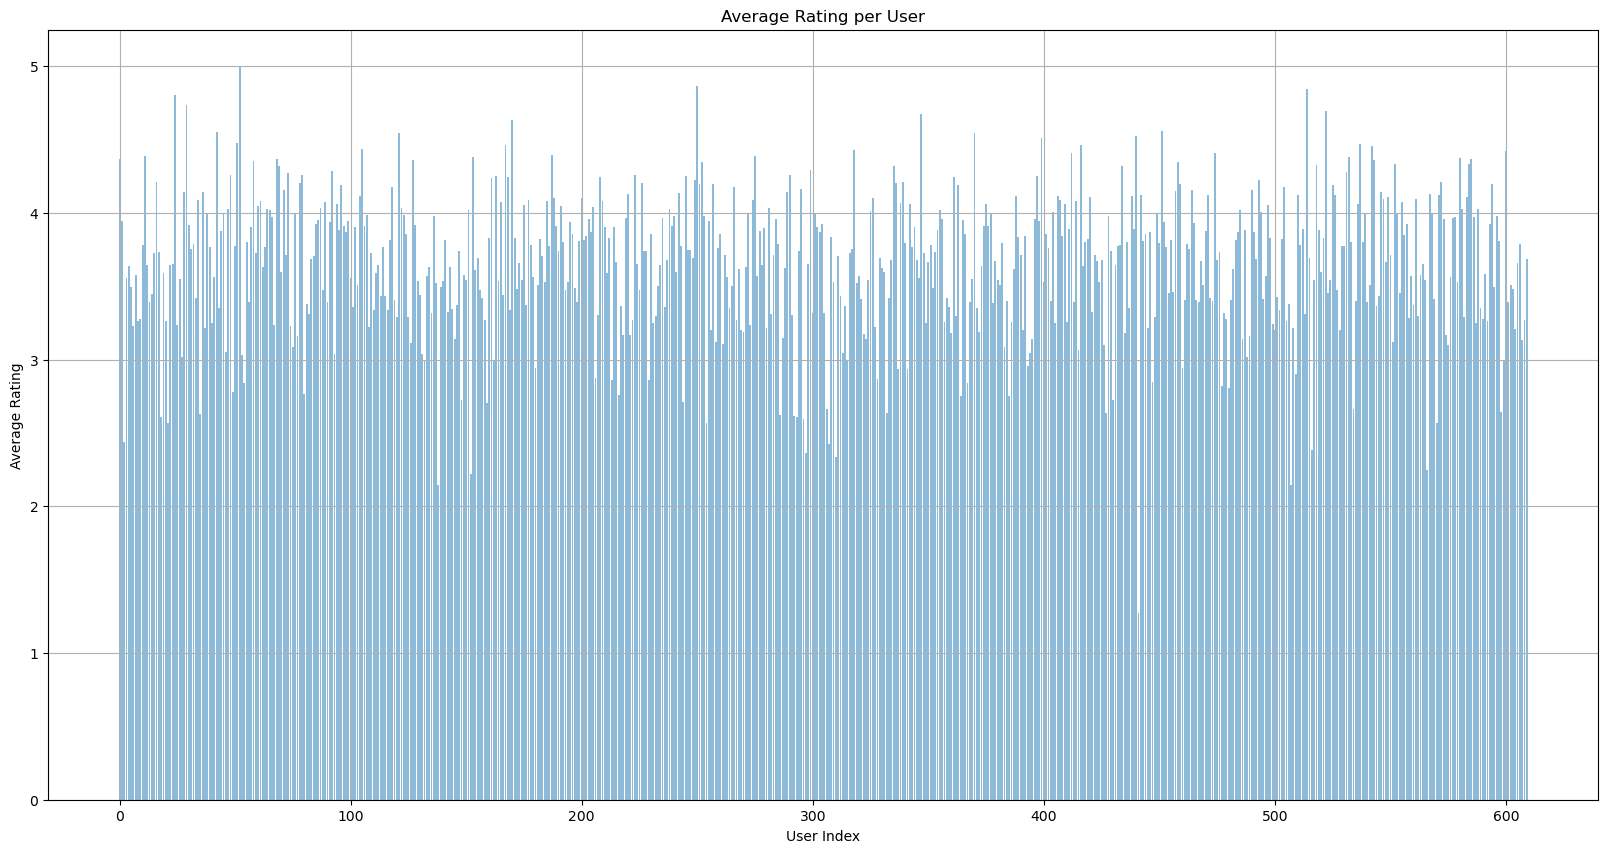

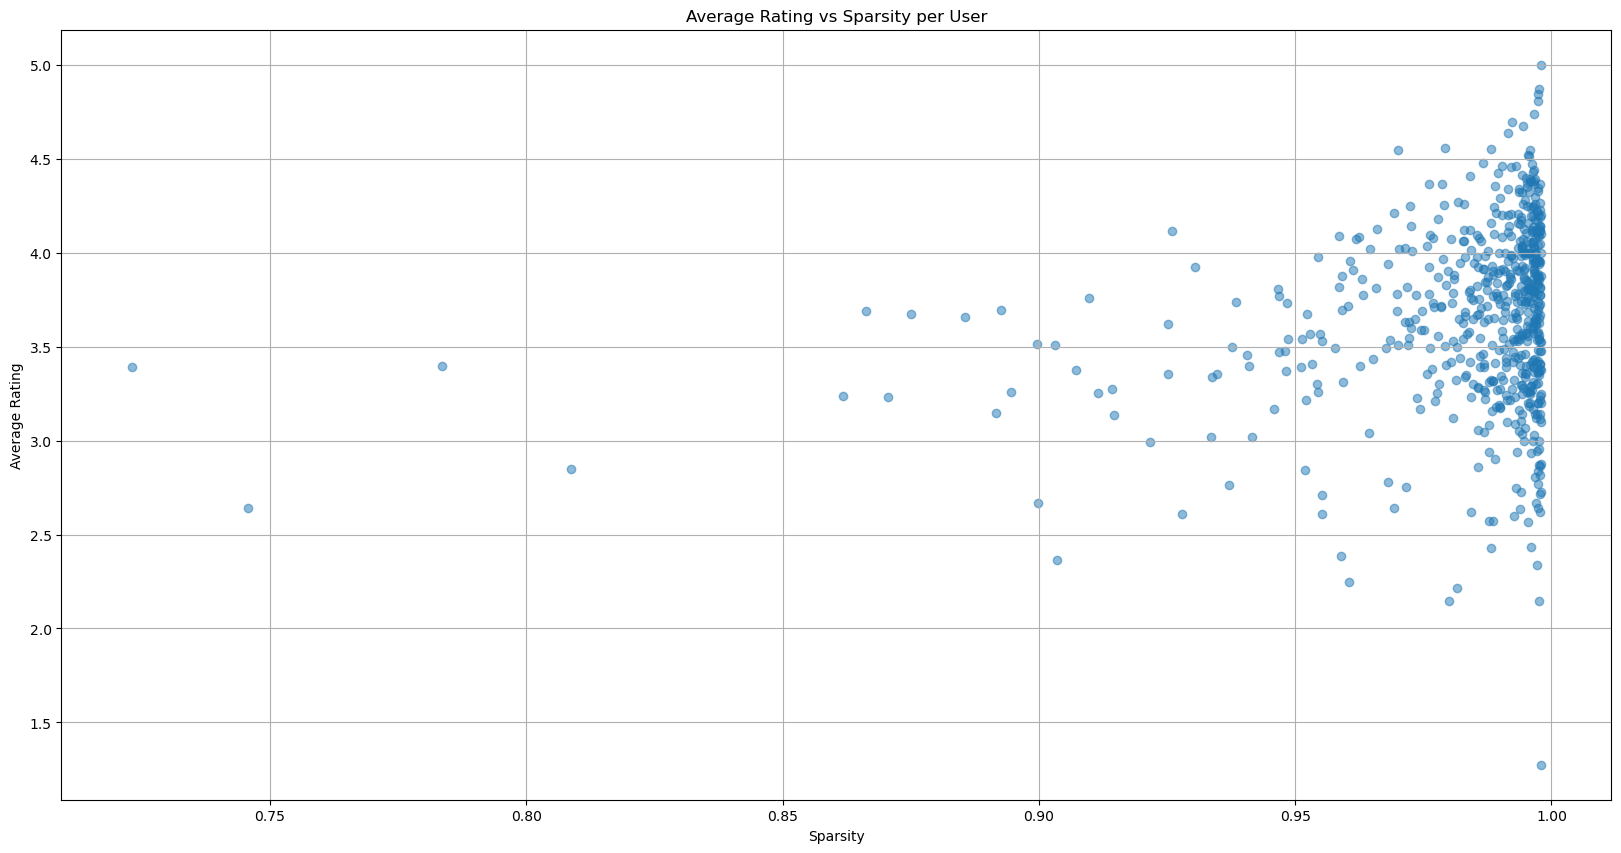

In [249]:
# Print the total number of users by checking the number of rows in the data matrix
print("Number of users: ", data_matrix.shape[0])

# Calculate the number of NaN entries in the data matrix to measure sparsity
total_entries = data_matrix.size
nan_entries = np.isnan(data_matrix).sum().sum()
print("Sparsity: ", nan_entries / total_entries)

# Create a bar chart showing the average rating per user
average_per_user = data_matrix.mean(axis=1)
indices = np.arange(data_matrix.shape[0])
plt.figure(figsize=(20, 10))
plt.bar(indices, average_per_user, alpha=0.5)
plt.title('Average Rating per User')
plt.xlabel('User Index')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

# Create a scatter plot to explore the relationship between sparsity and average ratings
sparcity_per_user = np.isnan(data_matrix).sum(axis=1) / data_matrix.shape[1]
plt.figure(figsize=(20, 10))
plt.scatter(sparcity_per_user, average_per_user, alpha=0.5)
plt.title('Average Rating vs Sparsity per User')
plt.xlabel('Sparsity')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

In [250]:
def nmf(X, n_components, test_indices, max_iter=1, tol=1e-6):
    """
        Perform non-negative matrix factorization (NMF) on a given data matrix X.
        
        Parameters:
            X (numpy.ndarray): The data matrix to be factorized, where missing values are represented as NaN.
            n_components (int): The number of latent features.
            test_indices (list of tuples): Indices in X where the data is missing and should be tested.
            max_iter (int): Maximum number of iterations to perform.
            tol (float): Tolerance for the stopping condition based on the Frobenius norm of the difference matrix.
        
        Returns:
            W (numpy.ndarray): Basis matrix where each column is a component.
            H (numpy.ndarray): Coefficient matrix that represents the contribution of each component to the original matrix.
            error (float): Frobenius norm of the difference between the original and reconstructed matrix at the end of factorization.
        """
    
    # Validate that all test indices refer to NaN entries in the original matrix
    for position in test_indices:
        assert np.isnan(X[position[0], position[1]])

    # Initialize the factor matrices W and H with random non-negative values
    known_mask = ~np.isnan(X)
    W = np.random.rand(X.shape[0], n_components)
    H = np.random.rand(n_components, X.shape[1])

    error = np.inf
    X_non_nan = np.nan_to_num(X, nan=0)
    # Iterate until maximum iterations or until error falls below the tolerance level
    for i in range(max_iter):
        X_hat = W @ H
        H = H * (W.T @ (known_mask * X_non_nan) / (W.T @ (known_mask * X_hat) + 1e-9))
        X_hat = W @ H
        W = W * ((known_mask * X_non_nan) @ H.T / ((known_mask * X_hat) @ H.T + 1e-9))

        frobenius_norm = np.linalg.norm(known_mask * (X_non_nan - X_hat), 'fro')
        error = frobenius_norm
        if frobenius_norm < tol:
            break

    return W, H, error

In [251]:
def cross_validation(V, nmf, n_components, k=5):

    """
    Perform k-fold cross-validation on the given data matrix V to evaluate the performance of NMF.
    
    Parameters:
        V (numpy.ndarray): The data matrix with potential NaNs indicating missing values.
        nmf (function): The NMF function to be validated.
        n_components (int): The number of latent features for NMF.
        k (int): The number of folds in the cross-validation.
    
    Returns:
        float: The average error across all folds.
    """

    # Find indices of non-NaN values in V
    non_nan_indices = np.argwhere(~np.isnan(V))

    # Shuffle these indices to randomize the folds
    np.random.shuffle(non_nan_indices)

    # Calculate the size of each fold
    fold_size = len(non_nan_indices) // k
    fold_errors = []

    for i in range(k):
        start = i * fold_size
        end = (i + 1) * fold_size
        test_indices = non_nan_indices[start:end]

        # Create a training version of V by setting the test indices to NaN
        V_train = np.copy(V)
        for position in test_indices:
            V_train[position[0], position[1]] = np.nan

        # Apply the NMF function to the training data
        W, H, _ = nmf(V_train, n_components, test_indices)

        V_hat = W @ H

        error_curent_fold = 0
        # Calculate the error for the current fold using the test indices
        for (row, col) in test_indices:
            error_curent_fold += (V[row, col] - V_hat[row, col]) ** 2

        # Average the error by the number of test points in the fold
        fold_errors.append(error_curent_fold / len(test_indices))

    return np.mean(fold_errors)

In [252]:
# List of different numbers of latent components to evaluate
list_components = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Initialize lists to store the results of the cross-validation
errors = []
computed_W = []
computed_H = []

# Set a random seed for reproducibility of random operations such as shuffling
np.random.seed(42)


for n_components in list_components:
    # Perform cross-validation on the dataset with the current number of components
    error = cross_validation(data_matrix.values, nmf, n_components, 5)
    print(f"Error for {n_components} components: {error}")
    errors.append(error)


Error for 10 components: 1.4329323496590138
Error for 20 components: 1.3271001000139377
Error for 30 components: 1.2899053013425057
Error for 40 components: 1.282705131503318
Error for 50 components: 1.275294989859373
Error for 60 components: 1.2609462327867529
Error for 70 components: 1.2614560880183343
Error for 80 components: 1.25901716312771
Error for 90 components: 1.2527794521251099
Error for 100 components: 1.2498730357811052


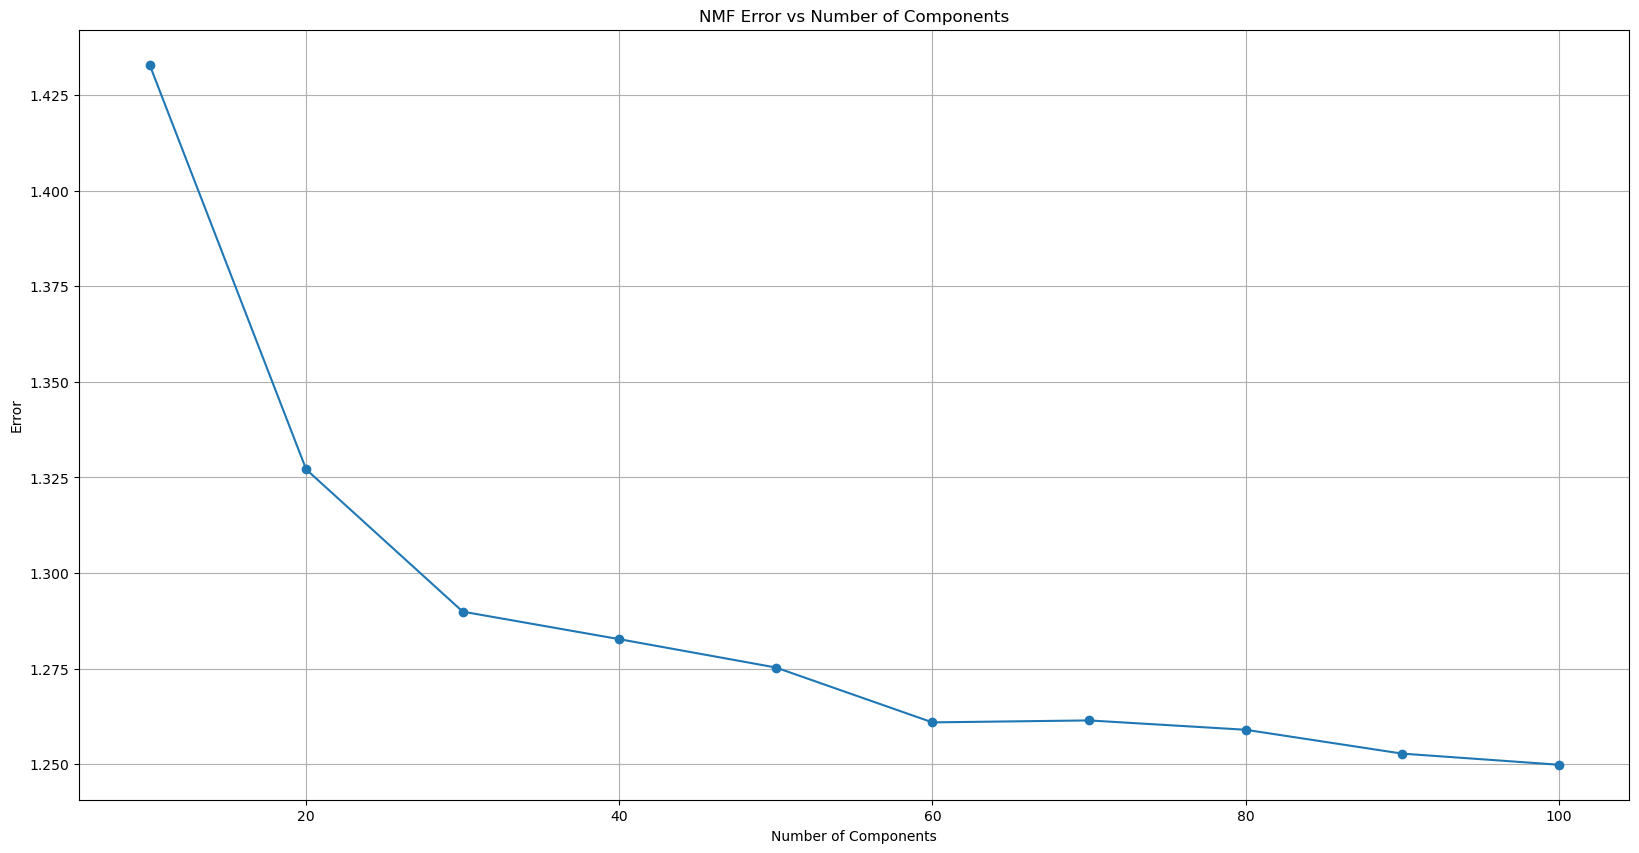

In [253]:
# Plot the error as a function of the number of components
plt.figure(figsize=(20, 10))
plt.plot(list_components, errors, marker='o')
plt.title('NMF Error vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Error')
plt.grid(True)
plt.show()

In [254]:
# Perform NMF on the full dataset with the optimal number of components
n_components = 90
W, H, _ = nmf(data_matrix.values, n_components, [])
predicted_ratings = W @ H

In [255]:
def recommend_movies(user_id, predicted_ratings, user_index_map, movie_index_map, n_recommendations=10):
    """
    Given a user's ID (in original user indexing),
    return top-N recommended movie IDs.
    """
    if(user_id not in user_index_map):
        return []
    
    # Map original user_id to internal index
    user_index = user_index_map[user_id]
    predicted_ratings_user = predicted_ratings[user_index, :]

    # Sort movie indices by descending rating
    indices = np.argsort(predicted_ratings_user)[::-1]

    # Convert movie indices back to original movie IDs
    inv_movie_index_map = {v: k for k, v in movie_index_map.items()}
    top_n_indices = [inv_movie_index_map[i] for i in indices[:n_recommendations]]
    return top_n_indices



In [256]:
print("Top 10 recommended movies for user 0:", recommend_movies(1, predicted_ratings, user_index_map, movie_index_map, 10))

Top 10 recommended movies for user 0: [6835, 84273, 117531, 3940, 187717, 467, 86237, 112512, 5723, 74226]


In [262]:
def build_movie_dict(movie_genres, movies, movie_index_map):
    """
    Create a dictionary mapping movie IDs to movie titles.
    """

    # Create a dictionary mapping movie IDs to movie titles
    all_genres = set()
    for movie in movie_genres:
        genres = movie_genres[movie][1]
        for g in genres:
            if g != '(no genres listed)':
                all_genres.add(g)

    all_genres = sorted(list(all_genres))
    genre_index_map = {genre: i for i, genre in enumerate(all_genres)}

    movie_genre_matrix = np.zeros((len(movies), len(all_genres)), dtype=np.float32)

    # Now create a matrix (num_movies, num_genres)
    for movie in movie_genres:

        genres = movie_genres[movie][1]
        movie_index = movie_index_map[movie]
        if '(no genres listed)' in genres:
            continue
        if movie_index is not None:
            for genre in genres:
                if genre in genre_index_map:
                    genre_index = genre_index_map[genre]
                    movie_genre_matrix[movie_index, genre_index] = 1.0

    return genre_index_map, movie_genre_matrix


In [258]:
def build_user_profile(user_id, user_index_map, data_matrix, movie_genre_matrix, rating_threshold=4.0):

    """
    Build a user's profile vector by averaging the genre vectors
    of movies they rated >= 'rating_threshold'.
    """

    user_index = user_index_map[user_id]
    # Extract the user's ratings row
    user_ratings = data_matrix[user_index, :]
    liked_movies = np.argwhere(user_ratings >= rating_threshold).flatten()

    if(len(liked_movies) == 0):
        return np.zeros(movie_genre_matrix.shape[1])
    
    # Average the genre vectors of the liked movies
    # the values in the final user_profile are between 0 and 1, 1 means the user likes that genre and 0 means the user doesn't like that genre
    user_profile = np.mean(movie_genre_matrix[liked_movies, :], axis=0)
    # Normalize the user profile vector
    norm = np.linalg.norm(user_profile)
    if norm > 0:
        user_profile /= norm
    
    return user_profile


In [259]:
def normalize_movie_genres(movie_genre_matrix):
    """
    Normalize the movie genre matrix by dividing each row by its norm.
    """

    for i in range(movie_genre_matrix.shape[0]):
        norm = np.linalg.norm(movie_genre_matrix[i, :])
        if norm > 0:
            movie_genre_matrix[i, :] /= norm
    return movie_genre_matrix

In [260]:
def recommend_content(user_id, data_matrix, normalized_movie_genres, movie_index_map, N = 5, rating_threshold=4.0):
    """
    Recommend the top-N movies for a user based on content filtering.
    """

    user_profile = build_user_profile(user_id, user_index_map, data_matrix, normalized_movie_genres, rating_threshold)
    
    # Dot product with each movie's vector to obtain the scores measuring the relevance of each movie to the user's preferences
    scores = normalized_movie_genres @ user_profile


    # Exclude movies the user has already rated
    user_index = user_index_map[user_id]
    user_ratings = data_matrix[user_index, :]
    rated_indices = np.argwhere(user_ratings > 0).flatten()

    assert len(rated_indices) == len(user_ratings[~np.isnan(user_ratings)])

    # We only want to consider movies not rated by this user
    mask = np.ones(len(scores), dtype=bool)
    mask[rated_indices] = False

    # Sort by descending score and return the top N indices
    indices = np.argsort(scores)[::-1]
    indices = indices[mask[indices]]
    top_n_indices = indices[:N]

    # Convert back to movie IDs
    inv_movie_index_map = {v: k for k, v in movie_index_map.items()}

    actual_ids = [inv_movie_index_map[i] for i in rated_indices]
    
    assert actual_ids == [318,333,1704,3578,6874,8798,46970,48516,58559,60756,68157,71535,74458,77455,79132,80489,80906,86345,89774,91529,91658,99114,106782,109487,112552,114060,115713,122882,131724]

    top_n_movies = []
    for i in top_n_indices:
        if i in inv_movie_index_map:
            top_n_movies.append(inv_movie_index_map[i])

    return top_n_movies


In [261]:
genre_index_map, movie_genre_matrix = build_movie_dict(movie_genres, movie_index_map)
normalized_movie_genres = normalize_movie_genres(movie_genre_matrix)
recommended_movies = recommend_content(2, data_matrix.values, normalized_movie_genres, movie_index_map, 10)
print("Top 10 recommended movies for user 2:", recommended_movies)

Top 10 recommended movies for user 2: [5027, 5628, 1432, 145, 20, 7007, 59947, 70728, 2002, 32460]
